In [20]:
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import numpy as np, pandas as pd
import sys
sys.path.append("utils")
import ds_utils as DU
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
repo = Path.cwd().parents[0]

IMG_SIZE = 96
tfm_tr = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, translate=(0.08,0.08)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor()
])
tfm_va = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor()])

In [3]:
class DS(Dataset):
    def __init__(self, df, root, tfm): self.df=df.reset_index(drop=True); self.root=root; self.tfm=tfm
    def __len__(self): return len(self.df)
    def __getitem__(self,i):
        r=self.df.iloc[i]; p=self.root/"Dataset/Create Dataset"/r["image_path"]
        img=Image.open(p).convert("L"); img=self.tfm(img)
        return img, int(r.get("label_id", DU.label2idx[r["label"]]))

df_tr=pd.read_csv(repo/"Dataset/Create Dataset/train.csv")
df_va=pd.read_csv(repo/"Dataset/Create Dataset/val.csv")
tr=DS(df_tr,repo,tfm_tr); va=DS(df_va,repo,tfm_va)
tr_dl=DataLoader(tr,batch_size=128,shuffle=True); va_dl=DataLoader(va,batch_size=256)

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(weights=None)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, len(DU.labels_))
model = resnet.to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
crit = nn.CrossEntropyLoss()


In [5]:
EPOCHS = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
max_norm = 1.0
patience = 4; bad = 0

history = {"train_acc": [], "val_acc": [], "val_f1": [], "lr": []}
best_state, best_f1 = None, 0.0

def eval_dl(mdl, dl):
    mdl.eval(); ys = []; ps = []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            out = mdl(x)
            ys.append(y.cpu().numpy())
            ps.append(out.argmax(1).cpu().numpy())
    y_true = np.concatenate(ys) if ys else np.array([])
    y_pred = np.concatenate(ps) if ps else np.array([])
    return DU.metrics(y_true, y_pred)

for ep in range(1, EPOCHS + 1):
    model.train(); tot = 0; corr = 0
    pbar = tqdm(tr_dl, desc=f"Epoch {ep}/{EPOCHS}", leave=False)
    for x, y in pbar:
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()

        if max_norm and max_norm > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        tot += y.size(0)
        corr += (out.argmax(1) == y).sum().item()

    train_acc = corr / tot if tot > 0 else float('nan')

    m = eval_dl(model, va_dl)
    acc = float(m.get("acc", m.get("accuracy", 0.0)))
    f1m = float(m.get("f1_macro", m.get("f1m", m.get("f1", 0.0))))

    history["train_acc"].append(train_acc)
    history["val_acc"].append(acc)
    history["val_f1"].append(f1m)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(f"[EP{ep}] train_acc={train_acc:.4f}  val_acc={acc:.4f}  val_f1={f1m:.4f}  lr={optimizer.param_groups[0]['lr']:.2e}")


    if f1m > best_f1:
        best_f1 = f1m
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
    if bad >= patience:
        print("Early stop.")
        break

    scheduler.step()

if best_state is not None:
    model.load_state_dict(best_state)

C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
Epoch 1/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\met

[EP1] train_acc=0.1454  val_acc=0.0312  val_f1=0.0019  lr=3.00e-04


Epoch 2/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

[EP2] train_acc=0.3702  val_acc=0.0312  val_f1=0.0019  lr=2.98e-04


Epoch 3/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

[EP3] train_acc=0.5075  val_acc=0.0312  val_f1=0.0022  lr=2.93e-04


Epoch 4/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

[EP4] train_acc=0.6603  val_acc=0.0625  val_f1=0.0158  lr=2.84e-04


Epoch 5/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

[EP5] train_acc=0.7534  val_acc=0.2938  val_f1=0.2271  lr=2.71e-04


Epoch 6/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Pars\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

[EP6] train_acc=0.8240  val_acc=0.4688  val_f1=0.3848  lr=2.56e-04


Epoch 7/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP7] train_acc=0.8635  val_acc=0.8875  val_f1=0.8827  lr=2.38e-04


Epoch 8/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP8] train_acc=0.8872  val_acc=0.8750  val_f1=0.8728  lr=2.18e-04


Epoch 9/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP9] train_acc=0.9096  val_acc=0.9563  val_f1=0.9538  lr=1.96e-04


Epoch 10/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP10] train_acc=0.9185  val_acc=0.9313  val_f1=0.9282  lr=1.73e-04


Epoch 11/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP11] train_acc=0.9402  val_acc=0.9437  val_f1=0.9448  lr=1.50e-04


Epoch 12/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP12] train_acc=0.9314  val_acc=0.9500  val_f1=0.9493  lr=1.27e-04


Epoch 13/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP13] train_acc=0.9504  val_acc=0.9750  val_f1=0.9747  lr=1.04e-04


Epoch 14/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP14] train_acc=0.9606  val_acc=0.9688  val_f1=0.9690  lr=8.19e-05


Epoch 15/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP15] train_acc=0.9633  val_acc=0.9625  val_f1=0.9620  lr=6.18e-05


Epoch 16/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP16] train_acc=0.9674  val_acc=0.9688  val_f1=0.9685  lr=4.39e-05


Epoch 17/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP17] train_acc=0.9688  val_acc=0.9875  val_f1=0.9874  lr=2.86e-05


Epoch 18/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP18] train_acc=0.9721  val_acc=0.9875  val_f1=0.9874  lr=1.63e-05


Epoch 19/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP19] train_acc=0.9640  val_acc=0.9875  val_f1=0.9874  lr=7.34e-06


Epoch 20/20:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\Pars\AppData\Local\Temp\ipykernel_24820\3133652684.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


[EP20] train_acc=0.9606  val_acc=0.9875  val_f1=0.9874  lr=1.85e-06


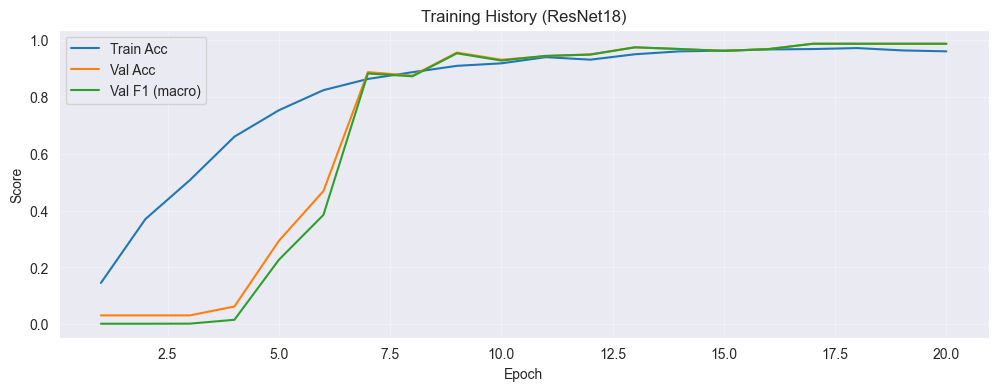

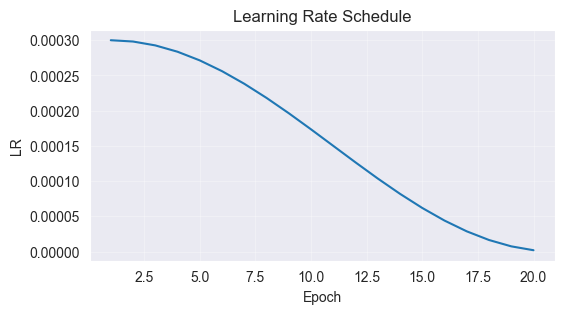

In [6]:
epochs = range(1, len(history["train_acc"]) + 1)

plt.figure(figsize=(12,4))
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.plot(epochs, history["val_f1"],  label="Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Training History (ResNet18)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(6,3))
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
plt.grid(True, alpha=0.3); plt.show()

In [7]:
if best_state:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "best_resnet18.pt")
    print("Saved best -> best_resnet18.pt")

Saved best -> best_resnet18.pt


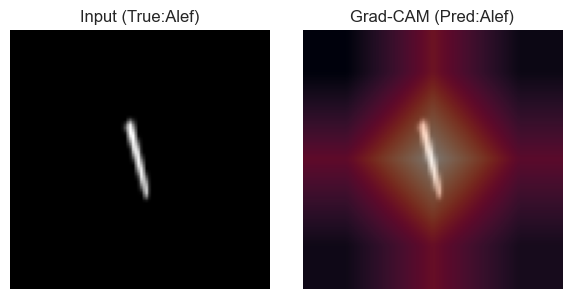

In [17]:
last_conv = None
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        last_conv = m
assert last_conv is not None, "No Conv2d found!"

acts=[]; grads=[]
def fwd_hook(m, inp, out): acts.append(out.detach())
def bwd_hook(m, gin, gout): grads.append(gout[0].detach())

h1 = last_conv.register_forward_hook(fwd_hook)
h2 = last_conv.register_backward_hook(bwd_hook)

# یک نمونه از val
x, y = next(iter(va_dl))
x0 = x[0:1].to(device); y0 = y[0].item()

# پیش‌بینی و بک‌پراپ برای کلاس پیش‌بینی‌شده
model.zero_grad()
out = model(x0)
cls = out.argmax(1).item()
out[0, cls].backward()

A = acts[-1][0]   # (C,H,W)
G = grads[-1][0]  # (C,H,W)
weights = G.mean(dim=(1,2), keepdim=True)    # (C,1,1)
cam = (A * weights).sum(0).cpu().numpy()     # (H,W)
cam = np.maximum(cam, 0)
cam = (cam - cam.min()) / (cam.max() + 1e-8)

img = x0[0,0].detach().cpu().numpy()
cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title(f"Input (True:{DU.idx2label[y0]})"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img, cmap='gray'); plt.imshow(cam_resized, alpha=0.5); plt.title(f"Grad-CAM (Pred:{DU.idx2label[cls]})"); plt.axis('off')
plt.tight_layout(); plt.show()

In [18]:
torch.save(model.state_dict(), "best_resnet18.pt")
print("Saved:", Path("best_resnet18.pt").resolve())

Saved: C:\Users\Pars\Desktop\my computer\taha\zohram\Ziraxa\project\ML\FarsiOCR\model\best_resnet18.pt
